## Assumptions:
* 256 MAC PEs at 1GHz means we can do 256 billion 32-bit MAC operations per second
* our MAC PEs are not optimized for more efficient computation when weights or activations are smaller
* ReLU function uses no MAC operations
* A MAC operation *is* a FLOP
* Memory overhead for feature maps is not to be considered as in that case then all bandwidths would be bounded by DRAM bandwidth

## 

## Credit
uses code from 

In [55]:
import numpy
import matplotlib.pyplot
import matplotlib

START = -2
STOP = 6
N = abs(STOP - START + 1)

def performance(peakPerformance, peakBandwidth, intensity):
    performance = numpy.zeros(len(intensity))
    performance = numpy.minimum(peakPerformance, peakBandwidth * intensity)
    return performance

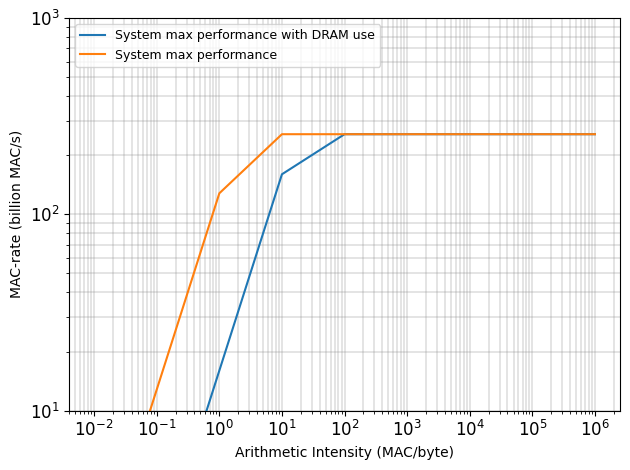

In [56]:
systemMaxPerformance = 256 # GFLOP/s
bandwidthSRAM = 128 # GB/s
bandwidthDRAM = 16 # GB/s

capacityWeightsSRAM = 0.000128 # GB
capacityActivationSRAM = 0.002 # GB

arithIntensity = numpy.logspace(START, STOP, num=N, base=10)

maxPerf = performance(systemMaxPerformance, bandwidthSRAM, arithIntensity)
maxPerfWithDRAM = performance(systemMaxPerformance, bandwidthDRAM, arithIntensity)

fig, axis = matplotlib.pyplot.subplots()
axis.set_xscale('log', base=10)
axis.set_yscale('log', base=10)
axis.set_xlabel('Arithmetic Intensity (MAC/byte)', fontsize=10)
axis.grid(True, which='both', color='gray', linestyle='-', linewidth=0.3)

matplotlib.pyplot.setp(axis, xticks=arithIntensity, yticks=numpy.logspace(1, 20, num=20, base=10))
matplotlib.pyplot.yticks(fontsize=12)
matplotlib.pyplot.xticks(fontsize=12)
axis.set_ylabel("MAC-rate (billion MAC/s)", fontsize=10)
axis.set_ylim(bottom=10, top=1000)

axis.plot(arithIntensity, maxPerfWithDRAM, label='System max performance with DRAM use')
axis.plot(arithIntensity, maxPerf, label='System max performance')


axis.legend(loc='upper left', prop={'size': 9})
fig.tight_layout()